### Multi-Class Model for Kaggle Tabular Playground Series June 2021 Using TensorFlow Decision Forests
### David Lowe
### November 11, 2021

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: This project aims to construct a predictive model using various machine learning algorithms and document the end-to-end steps using a template. The Kaggle Tabular Playground June 2021 dataset is a multi-class modeling situation where we attempt to predict one of several (more than two) possible outcomes.

INTRODUCTION: Kaggle wants to provide an approachable environment for relatively new people in their data science journey. Since January 2021, they have hosted playground-style competitions on Kaggle with fun but less complex, tabular datasets. The dataset used for this competition is synthetic but based on a real dataset and generated using a CTGAN. The original dataset deals with predicting the category on an eCommerce product given various attributes about the listing. Although the features are anonymized, they have properties relating to real-world features.

ANALYSIS: The average performance of the three decision forests algorithms achieved a logarithmic loss benchmark of 2.2783 using the validation dataset. After a series of tuning trials, the refined Gradient Boosted Trees model processed the training dataset with a final logarithmic loss score of 1.8932. When we processed Kaggle's test dataset with the final model, the model achieved a logarithmic loss score of 2.8624.

CONCLUSION: In this iteration, the Decision Forests model did not appear to be a suitable algorithm for modeling this dataset.

Dataset Used: Kaggle Tabular Playground 2021 June Data Set

Dataset ML Model: Multi-Class classification with categorical attributes

Dataset Reference: https://www.kaggle.com/c/tabular-playground-series-jun-2021/

One potential source of performance benchmark: https://www.kaggle.com/c/tabular-playground-series-jun-2021/leaderboard

Any predictive modeling machine learning project generally can be broken down into about six major tasks:

1. Prepare Environment
2. Summarize and Visualize Data
3. Train and Evaluate Models
4. Fine-tune and Improve Models
5. Finalize Model and Present Analysis

## Task 1 - Prepare Environment

In [1]:
# Install the necessary packages for Colab
# !pip install python-dotenv PyMySQL
!pip install tensorflow_decision_forests

In [2]:
!pip install wurlitzer

In [3]:
# Retrieve the GPU information from Colab
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, 
and then re-execute this cell.


In [4]:
# Retrieve the memory configuration from Colab
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
    print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
    print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
    print('re-execute this cell.')
else:
    print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

To enable a high-RAM runtime, select the Runtime → "Change runtime type"
menu, and then select High-RAM in the Runtime shape dropdown. Then, 
re-execute this cell.


In [5]:
# Retrieve the CPU information
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 2


### 1.a) Load libraries and modules

In [6]:
# Set the random seed number for reproducible results
RNG_SEED = 888

In [7]:
import random
random.seed(RNG_SEED)
import numpy as np
np.random.seed(RNG_SEED)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import math
from datetime import datetime
# import boto3
# from dotenv import load_dotenv
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.pipeline import Pipeline
from sklearn import compose
from sklearn import impute
import tensorflow as tf
tf.random.set_seed(RNG_SEED)
from tensorflow import keras
import tensorflow_decision_forests as tfdf

In [8]:
try:
  from wurlitzer import sys_pipes
except:
  from colabtools.googlelog import CaptureLog as sys_pipes

from IPython.core.magic import register_line_magic
from IPython.display import Javascript

### 1.b) Set up the controlling parameters and functions

In [9]:
# Begin the timer for the script processing
start_time_script = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
N_JOBS = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
NOTIFY_STATUS = False

# Set the percentage sizes for splitting the dataset
TEST_SET_RATIO = 0.2
VAL_SET_RATIO = 0.1

# Set the number of folds for cross validation
N_FOLDS = 5
N_ITERATIONS = 1

# Set various default modeling parameters
DEFAULT_LOSS = 'categorical_crossentropy'
DEFAULT_METRICS = ["accuracy", tf.keras.metrics.SparseCategoricalCrossentropy()]
DEFAULT_OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.001)
DEFAULT_INITIALIZER = tf.keras.initializers.RandomNormal(seed=RNG_SEED)
CLASSIFIER_ACTIVATION = 'softmax'
MAX_EPOCHS = 10
BATCH_SIZE = 32
NUM_CLASSES = 9

# Check the number of GPUs accessible through TensorFlow
print('Num GPUs Available:', len(tf.config.list_physical_devices('GPU')))

# Print out the TensorFlow version for confirmation
print('TensorFlow version:', tf.__version__)

# Check the version of TensorFlow Decision Forests
print("Found TensorFlow Decision Forests v" + tfdf.__version__)

Num GPUs Available: 0
TensorFlow version: 2.6.0
Found TensorFlow Decision Forests v0.2.0


In [10]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [11]:
# Reset the random number generators
def reset_random(x=RNG_SEED):
    random.seed(x)
    np.random.seed(x)
    tf.random.set_seed(x)

In [12]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [13]:
dataset_path = 'https://dainesanalytics.com/datasets/kaggle-tabular-playground-2021jun/train.csv'
df_dataset_import = pd.read_csv(dataset_path, index_col=False)

# Take a peek at the dataframe after import
print(df_dataset_import.head())

   id  feature_0  feature_1  ...  feature_73  feature_74   target
0   0          0          0  ...           0           0  Class_6
1   1          0          0  ...           1           0  Class_6
2   2          0          0  ...           0           0  Class_2
3   3          0          0  ...           3           0  Class_8
4   4          1          0  ...           0           0  Class_2

[5 rows x 77 columns]


In [14]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 77 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id          200000 non-null  int64 
 1   feature_0   200000 non-null  int64 
 2   feature_1   200000 non-null  int64 
 3   feature_2   200000 non-null  int64 
 4   feature_3   200000 non-null  int64 
 5   feature_4   200000 non-null  int64 
 6   feature_5   200000 non-null  int64 
 7   feature_6   200000 non-null  int64 
 8   feature_7   200000 non-null  int64 
 9   feature_8   200000 non-null  int64 
 10  feature_9   200000 non-null  int64 
 11  feature_10  200000 non-null  int64 
 12  feature_11  200000 non-null  int64 
 13  feature_12  200000 non-null  int64 
 14  feature_13  200000 non-null  int64 
 15  feature_14  200000 non-null  int64 
 16  feature_15  200000 non-null  int64 
 17  feature_16  200000 non-null  int64 
 18  feature_17  200000 non-null  int64 
 19  feature_18  200000 non-

In [15]:
print(df_dataset_import.describe())

                  id      feature_0  ...    feature_73     feature_74
count  200000.000000  200000.000000  ...  200000.00000  200000.000000
mean    99999.500000       0.972710  ...       2.94021       0.632005
std     57735.171256       3.941836  ...      10.78465       3.925310
min         0.000000       0.000000  ...       0.00000       0.000000
25%     49999.750000       0.000000  ...       0.00000       0.000000
50%     99999.500000       0.000000  ...       0.00000       0.000000
75%    149999.250000       1.000000  ...       1.00000       0.000000
max    199999.000000      61.000000  ...     130.00000      52.000000

[8 rows x 76 columns]


In [16]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

id            0
feature_0     0
feature_1     0
feature_2     0
feature_3     0
             ..
feature_71    0
feature_72    0
feature_73    0
feature_74    0
target        0
Length: 77, dtype: int64
Total number of NaN in the dataframe:  0


### 1.d) Data Cleaning

In [17]:
# Dropping features
df_dataset_import.drop(columns=['id'], inplace=True)

# Standardize the class column to the name of target
df_dataset_import = df_dataset_import.rename(columns={'claim':'target'})

# Take a peek at the dataframe after cleaning
print(df_dataset_import.head())

   feature_0  feature_1  feature_2  ...  feature_73  feature_74   target
0          0          0          6  ...           0           0  Class_6
1          0          0          0  ...           1           0  Class_6
2          0          0          0  ...           0           0  Class_2
3          0          0          7  ...           3           0  Class_8
4          1          0          0  ...           0           0  Class_2

[5 rows x 76 columns]


In [18]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 76 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   feature_0   200000 non-null  int64 
 1   feature_1   200000 non-null  int64 
 2   feature_2   200000 non-null  int64 
 3   feature_3   200000 non-null  int64 
 4   feature_4   200000 non-null  int64 
 5   feature_5   200000 non-null  int64 
 6   feature_6   200000 non-null  int64 
 7   feature_7   200000 non-null  int64 
 8   feature_8   200000 non-null  int64 
 9   feature_9   200000 non-null  int64 
 10  feature_10  200000 non-null  int64 
 11  feature_11  200000 non-null  int64 
 12  feature_12  200000 non-null  int64 
 13  feature_13  200000 non-null  int64 
 14  feature_14  200000 non-null  int64 
 15  feature_15  200000 non-null  int64 
 16  feature_16  200000 non-null  int64 
 17  feature_17  200000 non-null  int64 
 18  feature_18  200000 non-null  int64 
 19  feature_19  200000 non-

In [19]:
print(df_dataset_import.describe())

           feature_0      feature_1  ...    feature_73     feature_74
count  200000.000000  200000.000000  ...  200000.00000  200000.000000
mean        0.972710       1.168365  ...       2.94021       0.632005
std         3.941836       3.993407  ...      10.78465       3.925310
min         0.000000       0.000000  ...       0.00000       0.000000
25%         0.000000       0.000000  ...       0.00000       0.000000
50%         0.000000       0.000000  ...       0.00000       0.000000
75%         1.000000       1.000000  ...       1.00000       0.000000
max        61.000000      51.000000  ...     130.00000      52.000000

[8 rows x 75 columns]


In [20]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

feature_0     0
feature_1     0
feature_2     0
feature_3     0
feature_4     0
             ..
feature_71    0
feature_72    0
feature_73    0
feature_74    0
target        0
Length: 76, dtype: int64
Total number of NaN in the dataframe:  0


### 1.e) Splitting Data into Sets

In [21]:
# Use variable total_column_count to hold the number of columns in the dataframe
total_column_count = len(df_dataset_import.columns)

# Set up variable total_feature_count for the total number of attribute columns
total_feature_count = total_column_count-1

# We create attribute-only and target-only datasets (df_features_train and df_target_train)
df_target_train = df_dataset_import['target']
df_features_train = df_dataset_import.drop(['target'], axis=1)

print("df_dataset_import.shape: {} df_features_train.shape: {} df_target_train.shape: {}".format(df_dataset_import.shape, df_features_train.shape, df_target_train.shape))

df_dataset_import.shape: (200000, 76) df_features_train.shape: (200000, 75) df_target_train.shape: (200000,)


### 1.f) Set up the parameters for data visualization

In [22]:
# Set up the number of row and columns for visualization display. display_rows * display_columns should be >= total_feature_count
display_columns = 4
if total_feature_count % display_columns == 0 :
    display_rows = total_feature_count // display_columns
else :
    display_rows = (total_feature_count // display_columns) + 1

# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = display_columns * 4
fig_size[1] = display_rows * 4
plt.rcParams["figure.figsize"] = fig_size

In [23]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 2 - Summarize and Visualize Data

In [24]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

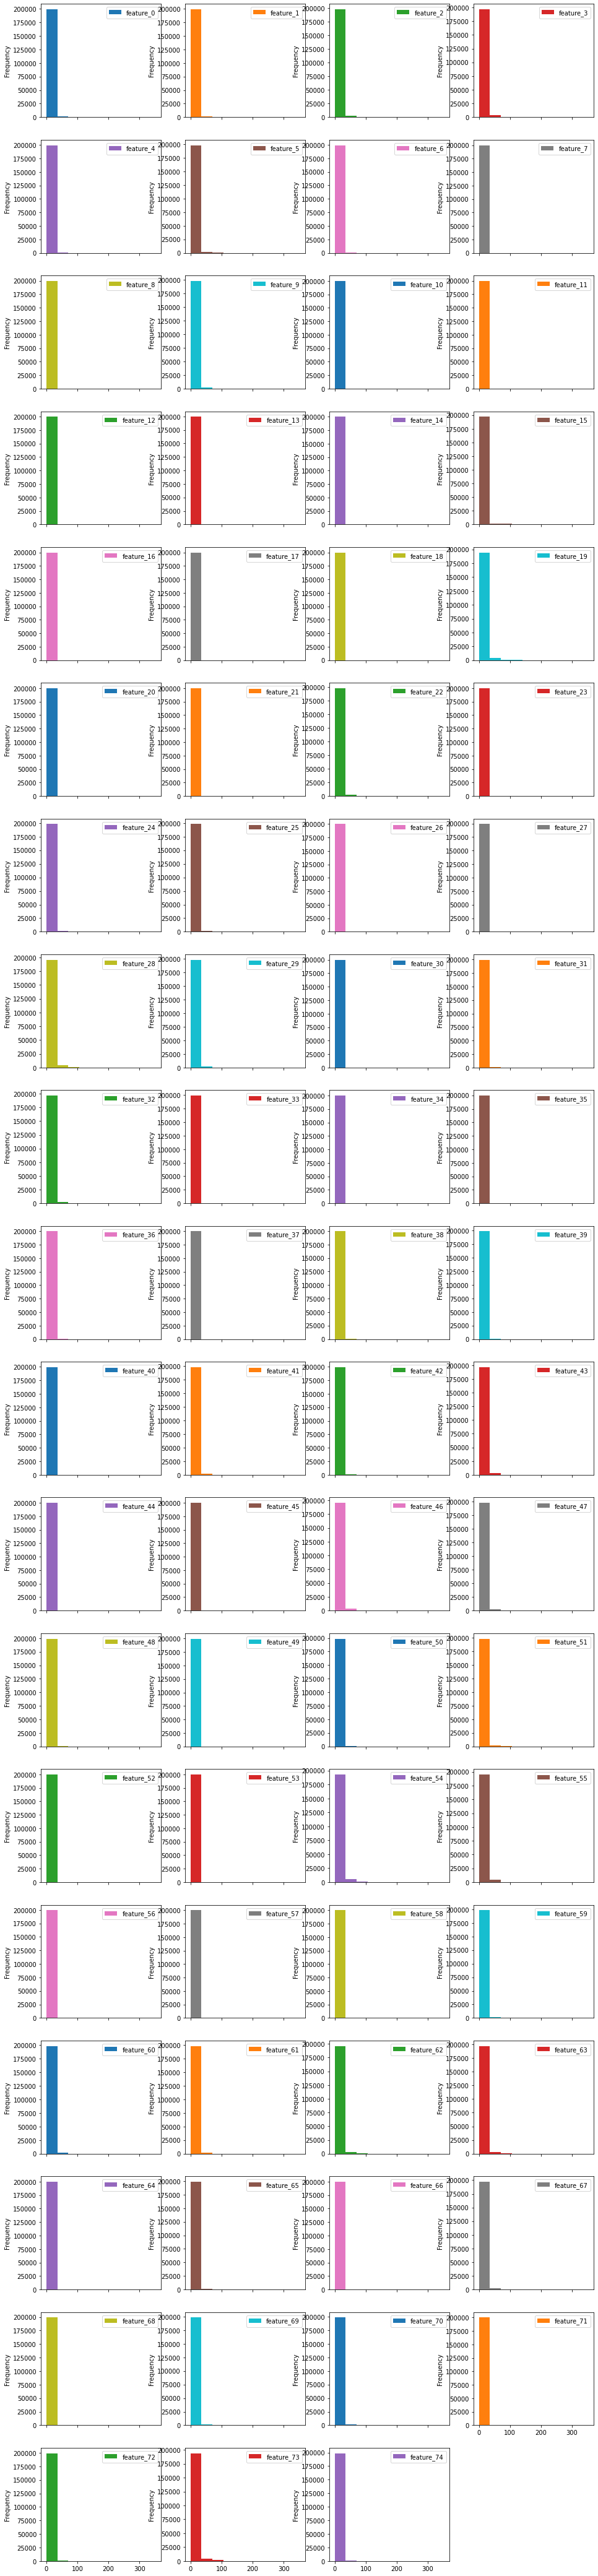

In [25]:
# Histograms for each attribute
df_features_train.plot(kind='hist', subplots=True, layout=(display_rows, display_columns))
plt.show()

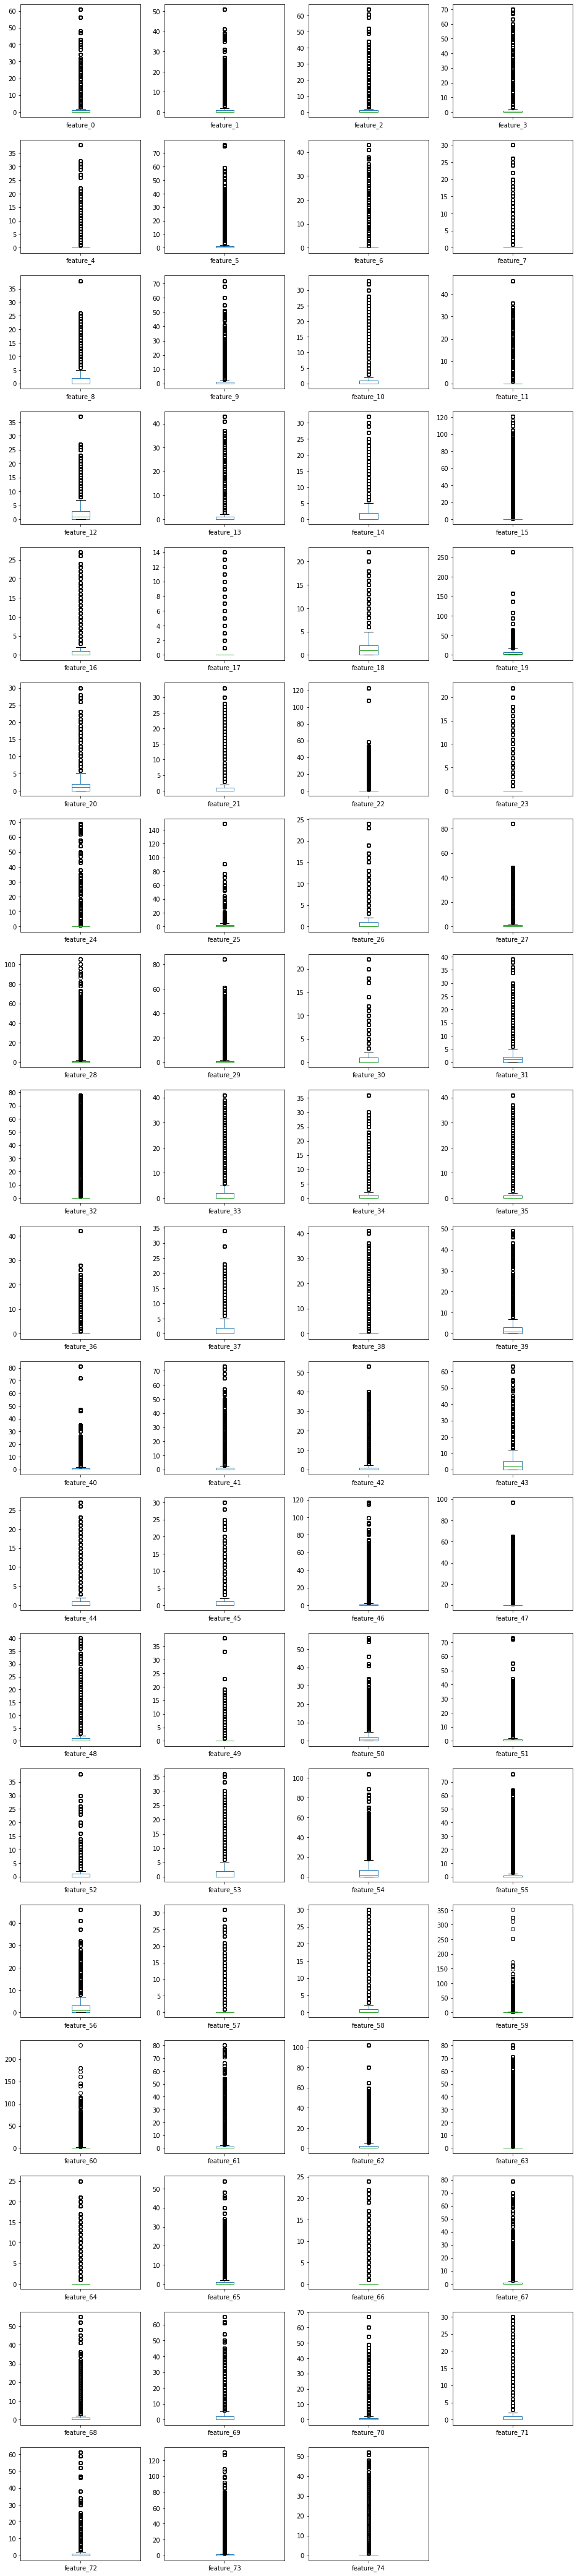

In [26]:
# Box and Whisker plot for each attribute
df_features_train.plot(kind='box', subplots=True, layout=(display_rows, display_columns))
plt.show()

In [27]:
# # Correlation matrix
# fig = plt.figure(figsize=(20, 20))
# correlations = df_features_train.corr(method='pearson')
# sns.heatmap(correlations, annot=True, cmap=plt.cm.PuBu)
# plt.show()

In [28]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 3 - Train and Evaluate Models

In [29]:
if NOTIFY_STATUS: status_notify("Task 3 - Train and Evaluate Models has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Splitting Data into Training and Validation Sets

In [30]:
# Encode the categorical label into an integer.
label = "target"

classes = df_dataset_import[label].unique().tolist()
print(f"Label classes: {classes}")

df_dataset_import[label] = df_dataset_import[label].map(classes.index)

Label classes: ['Class_6', 'Class_2', 'Class_8', 'Class_3', 'Class_1', 'Class_5', 'Class_7', 'Class_9', 'Class_4']


In [31]:
# Split the data further into training and validation datasets
df_dataset_train, df_dataset_valid = train_test_split(df_dataset_import, test_size=VAL_SET_RATIO, random_state=RNG_SEED)
print("df_dataset_train.shape: {} df_dataset_valid.shape: {}".format(df_dataset_train.shape, df_dataset_valid.shape))

df_dataset_train.shape: (180000, 76) df_dataset_valid.shape: (20000, 76)


In [32]:
# Finalize the training and validation datasets for the modeling activities
tfds_train = tfdf.keras.pd_dataframe_to_tf_dataset(df_dataset_train, label='target')
tfds_valid = tfdf.keras.pd_dataframe_to_tf_dataset(df_dataset_valid, label='target')

### 3.b) Train and Evaluate the Random Forest Model

In [33]:
# Define the baseline model for benchmarking
start_time_module = datetime.now()
reset_random()
model_1 = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.CLASSIFICATION)

# Optionally, add evaluation metrics.
model_1.compile(metrics=DEFAULT_METRICS)

# Train the model.
# "sys_pipes" is optional. It enables the display of the training logs.
with sys_pipes():
    model_1.fit(x=tfds_train)
print ('Model training time:', (datetime.now() - start_time_module), '\n')

2021-11-06 22:25:30.492154: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


2813/2813 [==============================] - 20s 5ms/step


[INFO kernel.cc:736] Start Yggdrasil model training
[INFO kernel.cc:737] Collect training examples
[INFO kernel.cc:392] Number of batches: 2813
[INFO kernel.cc:393] Number of examples: 180000
[INFO kernel.cc:759] Dataset:
Number of records: 180000
Number of columns: 76

Number of columns by type:
	NUMERICAL: 75 (98.6842%)
	CATEGORICAL: 1 (1.31579%)

Columns:

NUMERICAL: 75 (98.6842%)
	0: "feature_0" NUMERICAL mean:0.974422 min:0 max:61 sd:3.94454
	1: "feature_1" NUMERICAL mean:1.17072 min:0 max:51 sd:4.00036
	2: "feature_10" NUMERICAL mean:1.42286 min:0 max:33 sd:3.28837
	3: "feature_11" NUMERICAL mean:0.982267 min:0 max:46 sd:3.83721
	4: "feature_12" NUMERICAL mean:2.44457 min:0 max:37 sd:3.41683
	5: "feature_13" NUMERICAL mean:1.07723 min:0 max:43 sd:3.71324
	6: "feature_14" NUMERICAL mean:1.41029 min:0 max:32 sd:2.87856
	7: "feature_15" NUMERICAL mean:1.41198 min:0 max:121 sd:8.23604
	8: "feature_16" NUMERICAL mean:1.38821 min:0 max:27 sd:3.05093
	9: "feature_17" NUMERICAL mean:0.31

Model training time: 0:06:30.214006 



In [34]:
tfdf.model_plotter.plot_model_in_colab(model_1)

In [35]:
model_1.make_inspector().evaluation()

Evaluation(num_examples=180000, accuracy=0.3578277777777778, loss=4.099852778370187, rmse=None, ndcg=None, aucs=None)

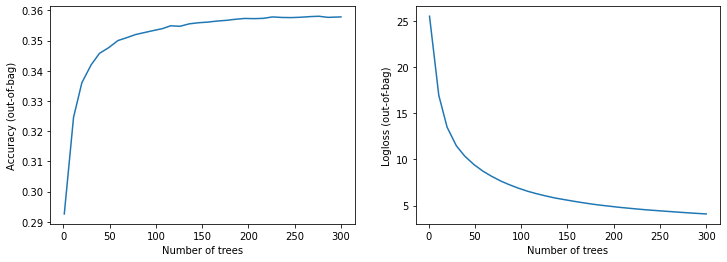

In [36]:
logs = model_1.make_inspector().training_logs()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")

plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Logloss (out-of-bag)")

plt.show()

In [37]:
evaluation = model_1.evaluate(tfds_valid, return_dict=True)
print()

for name, value in evaluation.items():
    print(f"{name}: {value:.4f}")

313/313 [==============================] - 5s 14ms/step - loss: 0.0000e+00 - accuracy: 0.3563 - sparse_categorical_crossentropy: 2.3722

loss: 0.0000
accuracy: 0.3563
sparse_categorical_crossentropy: 2.3722


### 3.c) Train and Evaluate the Decision Trees Model

In [38]:
# Define the baseline model for benchmarking
start_time_module = datetime.now()
reset_random()
model_2 = tfdf.keras.CartModel(task = tfdf.keras.Task.CLASSIFICATION)

# Optionally, add evaluation metrics.
model_2.compile(
    metrics=DEFAULT_METRICS)

# Train the model.
# "sys_pipes" is optional. It enables the display of the training logs.
with sys_pipes():
    model_2.fit(x=tfds_train)
print ('Model training time:', (datetime.now() - start_time_module), '\n')

2813/2813 [==============================] - 16s 6ms/step


[INFO kernel.cc:736] Start Yggdrasil model training
[INFO kernel.cc:737] Collect training examples
[INFO kernel.cc:392] Number of batches: 2813
[INFO kernel.cc:393] Number of examples: 180000
[INFO kernel.cc:759] Dataset:
Number of records: 180000
Number of columns: 76

Number of columns by type:
	NUMERICAL: 75 (98.6842%)
	CATEGORICAL: 1 (1.31579%)

Columns:

NUMERICAL: 75 (98.6842%)
	0: "feature_0" NUMERICAL mean:0.974422 min:0 max:61 sd:3.94454
	1: "feature_1" NUMERICAL mean:1.17072 min:0 max:51 sd:4.00036
	2: "feature_10" NUMERICAL mean:1.42286 min:0 max:33 sd:3.28837
	3: "feature_11" NUMERICAL mean:0.982267 min:0 max:46 sd:3.83721
	4: "feature_12" NUMERICAL mean:2.44457 min:0 max:37 sd:3.41683
	5: "feature_13" NUMERICAL mean:1.07723 min:0 max:43 sd:3.71324
	6: "feature_14" NUMERICAL mean:1.41029 min:0 max:32 sd:2.87856
	7: "feature_15" NUMERICAL mean:1.41198 min:0 max:121 sd:8.23604
	8: "feature_16" NUMERICAL mean:1.38821 min:0 max:27 sd:3.05093
	9: "feature_17" NUMERICAL mean:0.31

Model training time: 0:00:22.173067 



In [39]:
tfdf.model_plotter.plot_model_in_colab(model_2)

In [40]:
evaluation = model_2.evaluate(tfds_valid, return_dict=True)
print()

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

313/313 [==============================] - 2s 5ms/step - loss: 0.0000e+00 - accuracy: 0.3211 - sparse_categorical_crossentropy: 2.3260

loss: 0.0000
accuracy: 0.3211
sparse_categorical_crossentropy: 2.3260


### 3.d) Train and Evaluate the Gradient Boosted Trees Model

In [41]:
# Define the baseline model for benchmarking
start_time_module = datetime.now()
reset_random()
model_3 = tfdf.keras.GradientBoostedTreesModel(task = tfdf.keras.Task.CLASSIFICATION)

# Optionally, add evaluation metrics.
model_3.compile(
    metrics=DEFAULT_METRICS)

# Train the model.
# "sys_pipes" is optional. It enables the display of the training logs.
with sys_pipes():
    model_3.fit(x=tfds_train)
print ('Model training time:', (datetime.now() - start_time_module), '\n')

2813/2813 [==============================] - 16s 5ms/step


[INFO kernel.cc:736] Start Yggdrasil model training
[INFO kernel.cc:737] Collect training examples
[INFO kernel.cc:392] Number of batches: 2813
[INFO kernel.cc:393] Number of examples: 180000
[INFO kernel.cc:759] Dataset:
Number of records: 180000
Number of columns: 76

Number of columns by type:
	NUMERICAL: 75 (98.6842%)
	CATEGORICAL: 1 (1.31579%)

Columns:

NUMERICAL: 75 (98.6842%)
	0: "feature_0" NUMERICAL mean:0.974422 min:0 max:61 sd:3.94454
	1: "feature_1" NUMERICAL mean:1.17072 min:0 max:51 sd:4.00036
	2: "feature_10" NUMERICAL mean:1.42286 min:0 max:33 sd:3.28837
	3: "feature_11" NUMERICAL mean:0.982267 min:0 max:46 sd:3.83721
	4: "feature_12" NUMERICAL mean:2.44457 min:0 max:37 sd:3.41683
	5: "feature_13" NUMERICAL mean:1.07723 min:0 max:43 sd:3.71324
	6: "feature_14" NUMERICAL mean:1.41029 min:0 max:32 sd:2.87856
	7: "feature_15" NUMERICAL mean:1.41198 min:0 max:121 sd:8.23604
	8: "feature_16" NUMERICAL mean:1.38821 min:0 max:27 sd:3.05093
	9: "feature_17" NUMERICAL mean:0.31

Model training time: 0:06:20.581803 



In [42]:
tfdf.model_plotter.plot_model_in_colab(model_3)

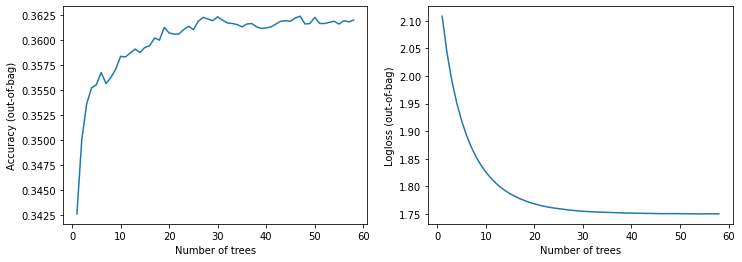

In [43]:
logs = model_3.make_inspector().training_logs()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")

plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Logloss (out-of-bag)")

plt.show()

In [44]:
evaluation = model_3.evaluate(tfds_valid, return_dict=True)
print()

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

313/313 [==============================] - 2s 6ms/step - loss: 0.0000e+00 - accuracy: 0.3573 - sparse_categorical_crossentropy: 2.1367

loss: 0.0000
accuracy: 0.3573
sparse_categorical_crossentropy: 2.1367


In [45]:
if NOTIFY_STATUS: status_notify("Task 3 - Train and Evaluate Models completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 4 - Fine-tune and Improve Models

In [46]:
if NOTIFY_STATUS: status_notify("Task 4 - Fine-tune and Improve Models has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [47]:
for num_trees in [300, 500, 750, 1000]:
    # Define the baseline model for benchmarking
    start_time_module = datetime.now()
    reset_random()
    model_tune = tfdf.keras.GradientBoostedTreesModel(num_trees=num_trees)

    # Optionally, add evaluation metrics.
    model_tune.compile(metrics=DEFAULT_METRICS)

    # Train the model.
    model_tune.fit(x=tfds_train, verbose=False)

    evaluation = model_tune.evaluate(tfds_valid, return_dict=True)
    print()

    for name, value in evaluation.items():
        print(f"{name}: {value:.4f}")
    print ('Model optimization time:', (datetime.now() - start_time_module), '\n')

313/313 [==============================] - 3s 6ms/step - loss: 0.0000e+00 - accuracy: 0.3573 - sparse_categorical_crossentropy: 2.0420

loss: 0.0000
accuracy: 0.3573
sparse_categorical_crossentropy: 2.0420
Model optimization time: 0:06:15.455347 



313/313 [==============================] - 3s 6ms/step - loss: 0.0000e+00 - accuracy: 0.3573 - sparse_categorical_crossentropy: 1.9852

loss: 0.0000
accuracy: 0.3573
sparse_categorical_crossentropy: 1.9852
Model optimization time: 0:06:16.934608 



313/313 [==============================] - 2s 6ms/step - loss: 0.0000e+00 - accuracy: 0.3573 - sparse_categorical_crossentropy: 1.9474

loss: 0.0000
accuracy: 0.3573
sparse_categorical_crossentropy: 1.9474
Model optimization time: 0:06:17.034423 

313/313 [==============================] - 2s 6ms/step - loss: 0.0000e+00 - accuracy: 0.3573 - sparse_categorical_crossentropy: 1.9203

loss: 0.0000
accuracy: 0.3573
sparse_categorical_crossentropy: 1.9203
Model optimization time: 0:06:17.886004 



In [48]:
if NOTIFY_STATUS: status_notify("Task 4 - Fine-tune and Improve Models completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 5 - Finalize Model and Present Analysis

In [49]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Present Analysis has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 5.a) Train the Final Model

In [50]:
# Finalize the training and validation datasets for the modeling activities
tfds_train = tfdf.keras.pd_dataframe_to_tf_dataset(df_dataset_import, label='target')

In [51]:
# Define the baseline model for benchmarking
start_time_module = datetime.now()
reset_random()
final_model = tfdf.keras.GradientBoostedTreesModel(num_trees=1000)

# Optionally, add evaluation metrics.
final_model.compile(
    metrics=DEFAULT_METRICS)

# Train the model.
# "sys_pipes" is optional. It enables the display of the training logs.
with sys_pipes():
    final_model.fit(x=tfds_train)
print ('Model training time:', (datetime.now() - start_time_module), '\n')

3125/3125 [==============================] - 17s 5ms/step


[INFO kernel.cc:736] Start Yggdrasil model training
[INFO kernel.cc:737] Collect training examples
[INFO kernel.cc:392] Number of batches: 3125
[INFO kernel.cc:393] Number of examples: 200000
[INFO kernel.cc:759] Dataset:
Number of records: 200000
Number of columns: 76

Number of columns by type:
	NUMERICAL: 75 (98.6842%)
	CATEGORICAL: 1 (1.31579%)

Columns:

NUMERICAL: 75 (98.6842%)
	0: "feature_0" NUMERICAL mean:0.97271 min:0 max:61 sd:3.94183
	1: "feature_1" NUMERICAL mean:1.16837 min:0 max:51 sd:3.9934
	2: "feature_10" NUMERICAL mean:1.42255 min:0 max:33 sd:3.28837
	3: "feature_11" NUMERICAL mean:0.980955 min:0 max:46 sd:3.83776
	4: "feature_12" NUMERICAL mean:2.44476 min:0 max:37 sd:3.42176
	5: "feature_13" NUMERICAL mean:1.07808 min:0 max:43 sd:3.71364
	6: "feature_14" NUMERICAL mean:1.40644 min:0 max:32 sd:2.86873
	7: "feature_15" NUMERICAL mean:1.4132 min:0 max:121 sd:8.24042
	8: "feature_16" NUMERICAL mean:1.38972 min:0 max:27 sd:3.05688
	9: "feature_17" NUMERICAL mean:0.31774

Model training time: 0:07:26.547547 



In [52]:
final_model.summary()

Model: "gradient_boosted_trees_model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "GRADIENT_BOOSTED_TREES"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (75):
	feature_0
	feature_1
	feature_10
	feature_11
	feature_12
	feature_13
	feature_14
	feature_15
	feature_16
	feature_17
	feature_18
	feature_19
	feature_2
	feature_20
	feature_21
	feature_22
	feature_23
	feature_24
	feature_25
	feature_26
	feature_27
	feature_28
	feature_29
	feature_3
	feature_30
	feature_31
	feature_32
	feature_33
	feature_34
	feature_35
	feature_36
	feature_37
	feature_38
	feature_39
	feature_4
	feature_40
	feature_41
	feature_42
	feature_43
	feature_44
	feature_45
	feature_46
	feature_47
	feature_48
	feature_49
	feature_5
	feature_50
	feature_51
	feature_52
	feature_53
	feature_54
	feat

In [53]:
tfdf.model_plotter.plot_model_in_colab(final_model)

In [54]:
evaluation = final_model.evaluate(tfds_valid, return_dict=True)
print()

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

313/313 [==============================] - 3s 7ms/step - loss: 0.0000e+00 - accuracy: 0.3762 - sparse_categorical_crossentropy: 1.8932

loss: 0.0000
accuracy: 0.3762
sparse_categorical_crossentropy: 1.8932


### 5.b) Load Test Dataset and Prepare the Submission File

In [55]:
dataset_path = 'https://dainesanalytics.com/datasets/kaggle-tabular-playground-2021jun/test.csv'
df_features_test = pd.read_csv(dataset_path, index_col=False)

# Take a peek at the dataframe after import
print(df_features_test.head())

       id  feature_0  feature_1  ...  feature_72  feature_73  feature_74
0  200000          0          0  ...           0           0           0
1  200001          1          2  ...           3           0           0
2  200002          0          1  ...           2           0           0
3  200003          0          0  ...           4           0           0
4  200004          0          0  ...           0           1           0

[5 rows x 76 columns]


In [56]:
df_kaggle_submission = pd.DataFrame()
df_kaggle_submission['id'] = df_features_test['id']
print(df_kaggle_submission.head())

       id
0  200000
1  200001
2  200002
3  200003
4  200004


In [57]:
# Dropping features
df_features_test.drop(columns=['id'], inplace=True)

# Take a peek at the dataframe after cleaning
print(df_features_test.head())

   feature_0  feature_1  feature_2  ...  feature_72  feature_73  feature_74
0          0          0          0  ...           0           0           0
1          1          2          0  ...           3           0           0
2          0          1          7  ...           2           0           0
3          0          0          0  ...           4           0           0
4          0          0          5  ...           0           1           0

[5 rows x 75 columns]


In [58]:
# Finalize the test dataset for the prediction activities
tfds_test = tfdf.keras.pd_dataframe_to_tf_dataset(df_features_test)

In [59]:
# Make batched predictions
test_predictions = final_model.predict(tfds_test)
print(test_predictions)

[[0.18106717 0.35479492 0.06420603 ... 0.03003896 0.11838318 0.02536263]
 [0.2380135  0.10326864 0.32800218 ... 0.0738954  0.12015518 0.02064823]
 [0.6542286  0.03239076 0.12983318 ... 0.0337701  0.07138718 0.01285913]
 ...
 [0.13368762 0.25616556 0.1555478  ... 0.05262829 0.14694977 0.02885602]
 [0.36566326 0.02703654 0.36243722 ... 0.07311309 0.08125483 0.01575937]
 [0.30538964 0.07783633 0.21767215 ... 0.07718722 0.15734309 0.02178524]]


In [60]:
dataset_path = 'https://dainesanalytics.com/datasets/kaggle-tabular-playground-2021jun/sample_submission.csv'
df_sample_submission = pd.read_csv(dataset_path, index_col=False)
df_sample_submission.drop(columns=['id'], inplace=True)
submission_header = list(df_sample_submission.columns)
print(submission_header)

['Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5', 'Class_6', 'Class_7', 'Class_8', 'Class_9']


In [61]:
df_kaggle_submission[submission_header] = test_predictions
print(df_kaggle_submission.head())

       id   Class_1   Class_2   Class_3  ...   Class_6   Class_7   Class_8   Class_9
0  200000  0.181067  0.354795  0.064206  ...  0.014995  0.030039  0.118383  0.025363
1  200001  0.238014  0.103269  0.328002  ...  0.013727  0.073895  0.120155  0.020648
2  200002  0.654229  0.032391  0.129833  ...  0.008918  0.033770  0.071387  0.012859
3  200003  0.230850  0.086935  0.226240  ...  0.016157  0.079001  0.187315  0.041913
4  200004  0.330245  0.093747  0.224918  ...  0.014079  0.056835  0.138845  0.032321

[5 rows x 10 columns]


In [62]:
submission_file = df_kaggle_submission.to_csv(header=True, index=False)
filename = 'submission_' + datetime.now().strftime('%Y%m%d-%H%M') + '.csv'
with open(filename, 'w') as f:
    f.write(submission_file)
    print('Completed writing output file: ' + filename)

Completed writing output file: submission_20211106-2311.csv


In [63]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Present Analysis completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [64]:
print ('Total time for the script:',(datetime.now() - start_time_script))

Total time for the script: 0:46:52.172530
